# **Image Classification : Rock, Paper, and Scissors**


Dalam project ini, kita akan membuat sebuah Image Classification model untuk mengklasifikasikan gambar batu, kertas, dan gunting dengan menggunakan Convolutional Neural Network

Dataset dapat diunduh melalui https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

**LOAD DATASET**

In [2]:
# Unzip dataset
import zipfile, os
files = "rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(files,'r')
zip_ref.extractall('dataset/')
zip_ref.close()

In [3]:
# Simpan lokasi tempat gambar batu, kertas, dan gunting berada
base_dir = "dataset/rockpaperscissors/rps-cv-images"

**DATA AUGMENTATION**

Augmentasi data bertujuan untuk memperbanyak data gambar berdasarkan beberapa aspek yang dapat disesuaikan dengan kebutuhan kita, misalnya kecerahan, rotasi, perbesaran, dan lain-lain.

In [4]:
# Buat Image Data Generator untuk Data Kita
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2, # Sesuaikan dengan kebutuhan, saya menggunakan 80% data train 20% data test
    brightness_range=[0.5,1.5],
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode="nearest"
)

In [5]:
# Buat data train dan data test generator berdasarkan Image Data Generator

# Data Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    batch_size=10,
    class_mode="categorical",
    classes=["paper","rock","scissors"],
    subset="training"
)

# Data Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    batch_size=10,
    class_mode="categorical",
    classes=["paper","rock","scissors"],
    subset="validation"
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


**MODELLING**

In [11]:
# Buat model Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential()

# Layer 1
model.add(Conv2D(32,kernel_size=(3,3), activation="relu",input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 2
model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3
model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.5))

# Layer 4
model.add(Dense(512,activation="relu"))

# Output
model.add(Dense(3,activation="softmax"))

In [12]:
# Lihat rangkuman dari model yang telah dibuat
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 74, 74, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)       

In [13]:
# Buat 3 jenis Callback untuk mengefisienkan proses modelling, yaitu ModelCheckpoint, EarlyStopping
# dan ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)


early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.0001,
    mode="min",
    verbose=1
)

In [14]:
# Compile model kita dengan mendefinisikan loss function, optimizer, dan metrics
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss="categorical_crossentropy",
    optimizer = RMSprop(),
    metrics=["accuracy"]
)

In [15]:
# Langkah selanjutnya adalah melakukan proses fitting model kita

history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch = len(train_generator),
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint, early_stopping,reduce_lr],
    verbose=2
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.08712, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 - 23s - loss: 7.0401 - accuracy: 0.4460 - val_loss: 1.0871 - val_accuracy: 0.3478 - lr: 0.0010 - 23s/epoch - 132ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.08712
176/176 - 20s - loss: 1.6723 - accuracy: 0.5979 - val_loss: 3.1221 - val_accuracy: 0.3318 - lr: 0.0010 - 20s/epoch - 114ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.08712
176/176 - 22s - loss: 0.7543 - accuracy: 0.7630 - val_loss: 1.2481 - val_accuracy: 0.4600 - lr: 0.0010 - 22s/epoch - 123ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.08712 to 0.55644, saving model to best_model.h5
176/176 - 22s - loss: 0.5851 - accuracy: 0.8081 - val_loss: 0.5564 - val_accuracy: 0.7849 - lr: 0.0010 - 22s/epoch - 122ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.55644
176/176 - 20s - loss: 0.4367 - accuracy: 0.8561 - val_loss: 0.6245 - val_accuracy: 0.8352 - lr: 0.0010 - 20s/epoch - 114ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.55644 to 0.36316, saving model to best

Weights yang diambil untuk digunakan model kita adalah yang diperoleh dari epoch 41 :

176/176 - 20s - loss: 0.1019 - accuracy: 0.9743 - val_loss: 0.0362 - val_accuracy: 0.9840 - lr: 8.0000e-06 - 20s/epoch - 113ms/step

Ini berarti model kita mendapatkan akurasi untuk data training sebesar 97.4% dan akurasi untuk data test sebesar 98.4%

**VISUALIZING MODEL ACCURACY & LOSS**

In [18]:
import matplotlib.pyplot as plt

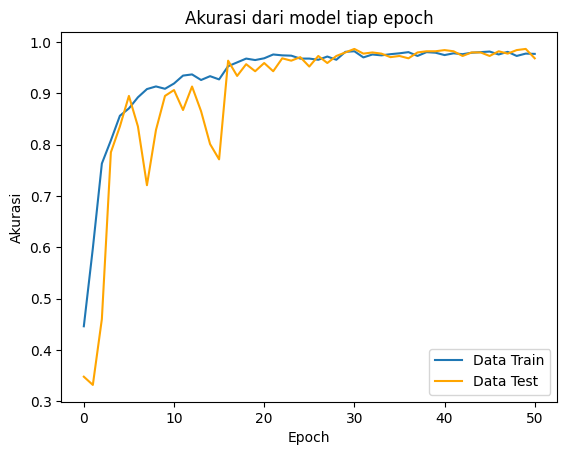

In [23]:
# Visualisasi akurasi model
plt.plot(history.history['accuracy'],label="Data Train")
plt.plot(history.history['val_accuracy'],color="orange",label="Data Test")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.title("Akurasi dari model tiap epoch")
plt.legend(loc="lower right")
plt.show()

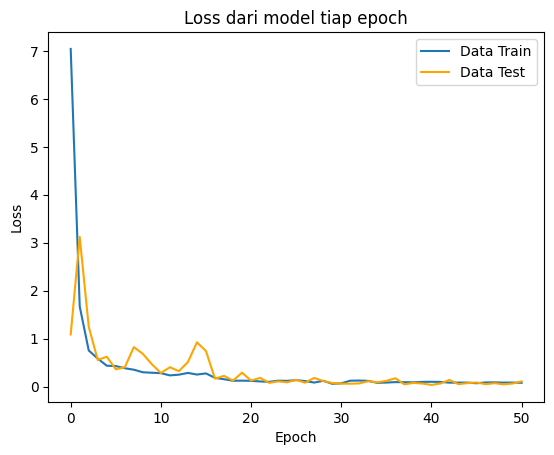

In [25]:
# Visualisasi loss model
plt.plot(history.history['loss'],label="Data Train")
plt.plot(history.history['val_loss'],color="orange",label="Data Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss dari model tiap epoch")
plt.legend(loc="upper right")
plt.show()

**USING MODEL TO PREDICT AN IMAGE**

In [27]:
# Cek kelas klasifikasi dalam model
print("Kelas di training generator : {}".format(train_generator.class_indices))
print("Kelas di validation generator : {}".format(validation_generator.class_indices))

Kelas di training generator : {'paper': 0, 'rock': 1, 'scissors': 2}
Kelas di validation generator : {'paper': 0, 'rock': 1, 'scissors': 2}


Saving IMG_20240123_073907.jpg to IMG_20240123_073907.jpg
1/1 [==============================] - 0s 140ms/step
IMG_20240123_073907.jpg
rock


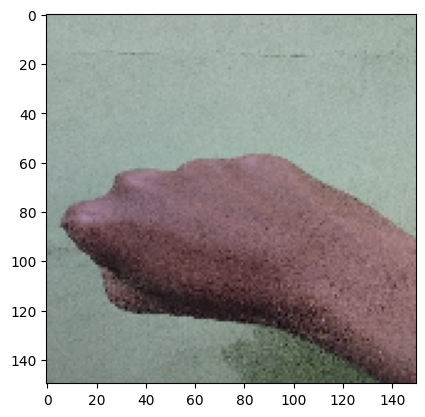

In [26]:
# Gunakan model untuk memprediksi gambar

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.image as impimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys() :
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = x/255.0
  x = np.expand_dims(x,axis=0)
  images = np.vstack([x])

  classes = model.predict(images,batch_size=10)[0]
  print(fn)
  index_selected = np.where(classes==classes.max())[0][0]
  if index_selected == 0 :
    print("paper")
  elif index_selected == 1 :
    print("rock")
  else :
    print("scissors")


**CONCLUSION**

Kita telah berhasil membuat sebuah model Convolutional Neural Network (CNN) untuk mengklasifikasikan gestur tangan berbentuk kertas, batu, atau gunting dengan akurasi pada data test sebesar 98.4%. Model juga telah berhasil mengidentifikasi gambar yang dimasukkan oleh user dengan tepat.

